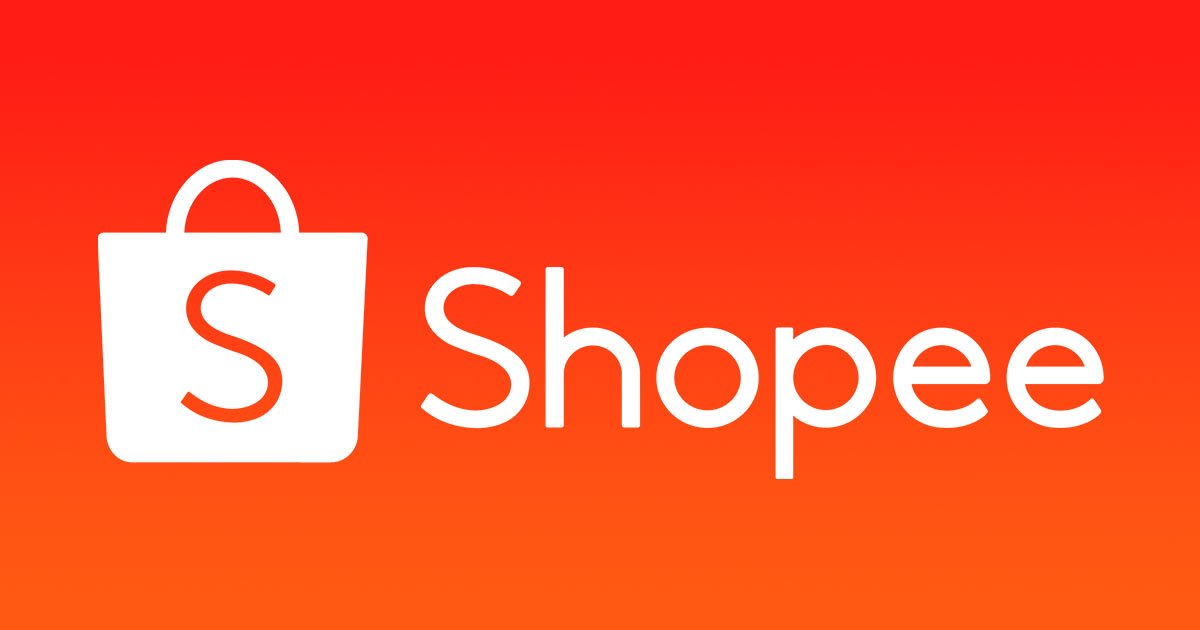

# Content of this Notebook:
*     This Notebook focuses mostly on visual representation of the text modelling output.
*     This notebook has preliminary visual outputs for Bag of Words(BoW),TF-IDF to find similarity in product titles and it will be updated frequently so do check regulary for new developments.
* Any feedback or feature requests are welcome. 


**Table of Contents:**
1. Data Description
2. Libraries and load Dataset
3. Basic EDA
4. Text Preprocessing
5. Bag Of Words(BoW)
6. TF-IDF


# 1.Data Description

Finding near-duplicates in large datasets is an important problem for many online businesses. In Shopee's case, everyday users can upload their own images and write their own product descriptions, adding an extra layer of challenge. Your task is to identify which products have been posted repeatedly. The differences between related products may be subtle while photos of identical products may be wildly different!

[train/test].csv - the training set metadata. Each row contains the data for a single posting. Multiple postings might have the exact same image ID, but with different titles or vice versa.

    posting_id - the ID code for the posting.

    image - the image id/md5sum.

    image_phash - a perceptual hash of the image.

    title - the product description for the posting.

    label_group - ID code for all postings that map to the same product. Not provided for the test set.


# 2.Libraries and Load Dataset
* All the necessary libraries are imported and we are working with train dataset only as our objective is to visualize the text modelling outputs.

In [ ]:
#import all the necessary packages.
import os
import re
import nltk
import time
import warnings
import numpy as np
import pandas as pd 
from PIL import Image
import seaborn as sns
from matplotlib import gridspec
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
warnings.filterwarnings("ignore")

In [ ]:
#Load data
data = pd.read_csv('../input/shopee-product-matching/train.csv')

In [ ]:
print('Number of data points : ', data.shape[0])
print('Number of features/variables:', data.shape[1])
print('Feature names : ', data.columns.tolist())

# Basic EDA Stats for the feature : title
* our focus will be on title column as we are going to apply techniques like BoW,TF-IDF....etc in this notebook

In [ ]:
print(data['title'].describe())

In [ ]:
# find the 10 most frequent titles.
title_count = Counter(list(data['title']))
title_count.most_common(10)

In [ ]:
# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))
#we have 1133 products which have same title.

# 4.Text Preprocessing

In [ ]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

In [ ]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

In [ ]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

In [ ]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

In [ ]:
# Utility Functions which we will use through the rest of this notebook
#Display an image
def display_img(img_id,ax,fig):
    images_path = '../input/shopee-product-matching/train_images/'
    img = Image.open(images_path + img_id)
    plt.figure(figsize=(3,3))
    # we will display it in notebook 
    plt.imshow(img, interpolation='nearest',aspect='auto')
    
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, img_id, text):
        gs = gridspec.GridSpec(2, 2, width_ratios=[8,1], height_ratios=[8,1]) 
        fig = plt.figure(figsize=(20,3))
        #1st plotting image
        ax = plt.subplot(gs[0])
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # product title
        
        # 2nd, plotting image 
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with parameter
        display_img(img_id,ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, img_id, text, model):

    # doc_id : index of the title1
    # vec1 : input product's vector, it is of a dict type {word:count}
    # vec2 : recommended product's vector, it is of a dict type {word:count}
    # img_id : image path
    # text: title of recomonded producr (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        

    intersection = set(vec1.keys()) & set(vec2.keys()) 
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, img_id, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, img_id, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, img_id, text2, model)

### Understanding Utility Functions 
* we will divide the whole figure into two parts.
* 1st, plotting heat map that represents the count of commonly ocurred words in title2.
* It displays a cell in white color if the word is intersection(list of words of title1 and list of words of title2), in black if not.
* 2nd, we plot the corresponding image
*  we find the common words in both titles, because these only words contribute to the distance between two title vec's.
* we set the values of non intersecting words to zero, this is just to show the difference in heatmap.

# 5.Bag of Words (BoW) on product titles.

In [ ]:
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() 

In [ ]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: product id in given corpus
    
    # pairwise_dist will store the distance from given input product to all remaining products
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. product_title, 2. title1, 3. title2, img_id, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]],  data['image'].loc[df_indices[i]], 'bag_of_words')
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
        

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(7, 20) # change the index if you want to.
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.
#you can try differnt product_id's to finid similar products:)

## BoW Observations:
*  **A simple BoW model was able to give similar products for the query product title, Interesting observation was the most of the recommended similar products(Fashion wear) has the same pattern style wear**
* **All the recommended items are related to fashion for women and was able to rightly pick clothing**

# 6. TF-IDF on Product titles

In [ ]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

In [ ]:
def tfidf_model(doc_id, num_results):
    # doc_id: product's id in given corpus
    
    # pairwise_dist will store the distance from given input product to all remaining products
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. product_title, 2. title1, 3. title2, img_id, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['image'].loc[df_indices[i]], 'tfidf')
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*60)
tfidf_model(7, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title

## TF-IDF Observations:
* **we picked the same query product title which was used earlier for BoW and applied TF-IDF algorithm and the results were improved compared to Bow model(expected).**
* **we can see few new recommendations in TF-IDF and the ranking has been improved for some of the items.**
* **Few of the duplicated items are repeated in the top recommendation which we will handle them later on**


  ## Thanks for reading, will keep posting more visualizations with diferent techniques.
  ## Stay Tuned and upvote if you like this notebook